# Compute fst within the 3R chrom

In [ ]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

### importing necessary package

In [ ]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [ ]:
import random
import functools
import petl as ptl
import itertools
import scipy
from collections import Counter

In [ ]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir 
results_dir = "drive/MyDrive/Genomic/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set    
Let's select the the sample set from 

In [ ]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140", 
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
bf_samples = df_samples.query('country == "Burkina Faso" and aim_species =="coluzzii"')
#bf_samples.groupby(['location', 'aim_species']).size()

#To access to the genotypes within the 3R chromosomes
chrom3R_gt = ag3.snp_calls(region="3R", sample_sets=sets)

# Take some SNP in the 3R chromosomes 
snps_pos = allel.SortedIndex(chrom3R_gt['variant_position'].values)

In [ ]:
#Create population column 
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, pop_labels,pop_colors, = [], [], {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:4]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#pop_labels
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])

#remove some populations 
pop_rm = ['Bana_ara', 'Bana_int', 'Sour_ara',  'Pala_col', 'Pala_int']
del s1, s2, val, colored
# remove pop_function
def remove_pop(list1, list2):
  for item in list2:
    list1.remove(item)
  return list1
pop_coh = remove_pop(pop_ids.copy(), pop_rm)

In [ ]:
#To the genomics dataset of bf samples 
bf_snps = chrom3R_gt.sel(samples=df_samples.eval('country=="Burkina Faso" and year > 2004'))

# Take some SNP in the 3R chromosomes 
bf_snps_pos = allel.SortedIndex(bf_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array 
filt = 'gamb_colu_arab' 
filt_val = bf_snps[f"variant_filter_pass_{filt}"].values 
gt_filtered = allel.GenotypeDaskArray(bf_snps["call_genotype"][filt_val].data)


In [ ]:
# compute allele counts  
#with ProgressBar():
  #ac = gt_filtered.count_alleles(max_allele=3).compute()
  #ac_pop = gt_filtered.count_alleles_subpops(coh_pop)

ac_pop = {} ## compute allele counts pop - dict
with ProgressBar():
  for pop in coh_pop.keys():
    ac_pop[pop] = gt_filtered.take(coh_pop[pop],axis=1).count_alleles(max_allele=3).compute()

[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 25min 32.9s
[########################################] | 100% Completed | 10min 51.0s
[########################################] | 100% Completed |  1min  1.8s
[########################################] | 100% Completed | 13min 36.5s
[########################################] | 100% Completed |  1min 43.1s
[########################################] | 100% Completed | 19min 50.3s
[########################################] | 100% Completed | 55.2s
[########################################] | 100% Completed | 59.7s
[########################################] | 100% Completed | 20min 51.7s
[########################################] | 100% Completed | 17min 29.4s


# Fst

In [ ]:
@functools.lru_cache(maxsize=None)
def load_ac(pop):
    ac_popi = ac_pop[pop]
    return ac_popi
#load_ac(pop='Bana_col')

In [ ]:
@functools.lru_cache(maxsize=None)
def compute_pair_fst(pops, blen=10000):
    # order is irrelevant
    pop1, pop2 = pops
    ac_pop1 = load_ac(pop=pop1)
    ac_pop2 = load_ac(pop=pop2)
    loc_pass = ac_pop1.is_segregating() & ac_pop2.is_segregating() & (ac_pop1.max_allele() <= 1) & (ac_pop2.max_allele() <= 1)
    ac1 = ac_pop1[loc_pass]
    ac2 = ac_pop2[loc_pass]
    
    # compute Fst
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen)
    
    return fst, se

In [ ]:
def compute_pairwise_fst(pop_coh, blen=10000):
    pairwise_fst = []
    pairwise_fst_se = []
    for pop1, pop2 in itertools.combinations(pop_coh, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_pair_fst(pops=pops, blen=blen)
        pairwise_fst.append(fst)
        pairwise_fst_se.append(se)
    return pairwise_fst, pairwise_fst_se

In [ ]:
def tabulate_pairwise_fst(pop_coh, blen=10000):
    fst, se = compute_pairwise_fst(pop_coh, blen=blen)
    fstsq = scipy.spatial.distance.squareform(fst)
    sesq = scipy.spatial.distance.squareform(se)
    data = [zip(r1, r2) for r1, r2 in zip(fstsq, sesq)]
    tbl_fst = (ptl
               .wrap(data)
               .pushheader(pop_coh)
               .convertall(lambda v: '' if v == (0, 0) else '%.04f (%.04f)' % v)
               .addcolumn('population', pop_coh, index=0)
               )
    tbl_fst.displayall(index_header=False, caption='Fst (standard error)')

In [ ]:
def plot_pairwise_fst(fst, se, pop_coh, figsize=(7, 4), mask=True, ax=None, fig_name=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=False, bottom=True, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((210, 90, 60), input="husl")), 
                mask=mask, cbar=False, annot=True, fmt='.2f', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(fst)/np.array(se)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, vmax=100, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.1f', )
    
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left', fontweight='bold')
    ax.set_yticklabels(ytl, rotation=0, ha='right', fontweight='bold')
    ax.tick_params(length=0, pad=3)
    ax.set_xlabel('Chrom 3R - $F_{ST}$')
    ax.set_ylabel('$Z$ score')
    ax.yaxis.set_label_position('right')
    
    fig.tight_layout()

    #save fig
    if fig_name:
      fig.savefig(f'drive/MyDrive/Genomic/Fst/{fig_name}.png', dpi=300, bbox_inches='tight')


In [ ]:
fst_pop, se_pop = compute_pairwise_fst(sorted(pop_coh), blen=50000)

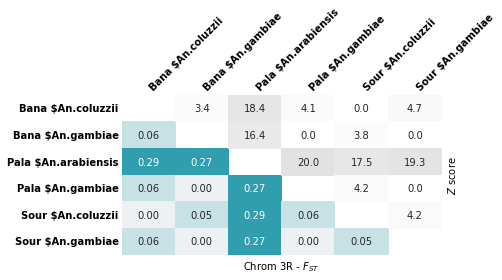

In [ ]:
plot_pairwise_fst(fst=fst_pop, se=se_pop, pop_coh=sorted(pop_coh), fig_name='3R_Fst')

In [ ]:
## Save year to year fst data 
fst_3R = np.array([fst_pop, se_pop])
np.save('drive/MyDrive/Genomic/Fst/data_fst/3R_fst', fst_3R)
print('Done...!')

Done...!
